In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import torch
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from nerfstudio.utils.eval_utils import eval_setup
from inerf.inerf_trainer import load_data_into_trainer
from inerf.inerf_utils import get_corrected_pose, load_eval_image_into_pipeline, get_relative_pose, get_absolute_diff_for_pose, get_image

In [3]:
os.chdir('/workspace')
MODEL_PATH = "/workspace/outputs/jackal_logo_training_data_1/plane-nerf/2024-02-20_103307"
DATA_PATH = "/stored_data/jackal_one_frame_logo"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "ground_truth.json")
TRANSFORM_FILE = "transforms.json"
with open(GROUND_TRUTH_PATH) as f:
    GROUND_TRUTH = json.load(f)
with open(os.path.join(DATA_PATH, TRANSFORM_FILE)) as f:
    TRANSFORM = json.load(f)

In [4]:
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, _, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )

pipeline = load_eval_image_into_pipeline(pipeline,DATA_PATH,TRANSFORM)

config.pipeline.datamanager.pixel_sampler.num_rays_per_batch = 4096 

trainer = load_data_into_trainer(
    config,
    pipeline,
    plane_optimizer = True
)

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_logo_training_data_1/plane-nerf/2024-02-20_103307/nerfstudio_models/step-000009999.ckpt

/workspace/inerf/inerf/inerf_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  camera_to_worlds = torch.cat([camera_to_worlds, tensor([tf]).float()], 0)


Setting up training dataset...

Caching all 1 images.

Output()

Loading PlaneNerfCameraOptimizer


[14:40:23] Saving checkpoints to:                                                                         ]8;id=671668;file:///usr/local/lib/python3.10/dist-packages/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=405402;file:///usr/local/lib/python3.10/dist-packages/nerfstudio/engine/trainer.py#136\136]8;;\
           outputs/jackal_logo_training_data_1/plane-nerf/2024-02-20_103307/nerfstudio_models                           

Loading latest Nerfstudio checkpoint from load_dir...


Done loading Nerfstudio checkpoint from 
outputs/jackal_logo_training_data_1/plane-nerf/2024-02-20_103307/nerfstudio_models/step-000009999.ckpt

In [5]:
trainer.pipeline.datamanager.KERNEL_SIZE = 5
trainer.pipeline.datamanager.THRESHOLD = 40
trainer.pipeline.datamanager.METHOD = "sift"
trainer.pipeline.datamanager.get_inerf_batch()  
trainer.pipeline.datamanager.inerf_batch["image"] = trainer.pipeline.datamanager.inerf_batch["image"].to(trainer.pipeline.device)
trainer.pipeline.train()

Number of keypoints:  126
Number of rays:  5369
Reduce the number of rays
Final number of rays:  4096


PlaneNerfPipeline(
  (datamanager): PlaneNerfDataManager(
    (train_ray_generator): RayGenerator()
  )
  (_model): PlaneNerfModel(
    (collider): NearFarCollider()
    (field): PlaneNerfField(
      (spatial_distortion): SceneContraction()
      (embedding_appearance): Embedding(
        (embedding): Embedding(300, 32)
      )
      (direction_encoding): SHEncoding(
        (tcnn_encoding): Encoding(n_input_dims=3, n_output_dims=16, seed=1337, dtype=torch.float32, hyperparams={'degree': 4, 'otype': 'SphericalHarmonics'})
      )
      (position_encoding): NeRFEncoding(
        (tcnn_encoding): Encoding(n_input_dims=3, n_output_dims=12, seed=1337, dtype=torch.float32, hyperparams={'n_frequencies': 2, 'otype': 'Frequency'})
      )
      (mlp_base_grid): HashEncoding(
        (tcnn_encoding): Encoding(n_input_dims=3, n_output_dims=32, seed=1337, dtype=torch.float32, hyperparams={'base_resolution': 16, 'hash': 'CoherentPrime', 'interpolation': 'Linear', 'log2_hashmap_size': 19, 'n_featu

In [6]:
ground_truth_poses = []
for _ , batch in pipeline.datamanager.fixed_indices_train_dataloader:
    tf = GROUND_TRUTH["frames"][int(batch['image_idx'])]["transform_matrix"]
    tf = np.asarray(tf)
    tf = tf[:3, :4 ]
    ground_truth_poses.append(tf)
ground_truth_poses = torch.tensor(ground_truth_poses).to(pipeline.device)

In [7]:
original_img = cv2.imread(os.path.join(DATA_PATH, GROUND_TRUTH["frames"][0]["file_path"]))
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

In [8]:
train_loop = 10
n = 100
lr_max = 5e-3
lr_min = 1e-3
store = torch.tensor([])

corrected_pose = get_corrected_pose(trainer)
#print(corrected_pose)
relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)
#Get averrage absolute translation and rotation error
print("Average translation error: ", torch.mean(t_diff))
print("Average rotation error: ", torch.mean(r_diff))

store = torch.cat((store, torch.tensor([[0, torch.mean(t_diff), torch.mean(r_diff)]])), 0)

for i in range(train_loop):
    for j in range(n):
        lr = lr_min + (lr_max - lr_min) * (i / train_loop)
        loss = trainer.train_iteration_inerf(optimizer_lr = lr)
    corrected_pose = get_corrected_pose(trainer)
    #print(corrected_pose)
    relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
    t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)
    store = torch.cat((store, torch.tensor([[i+1, torch.mean(t_diff), torch.mean(r_diff)]])), 0)
    #Get averrage absolute translation and rotation error
    print("Average translation error: ", torch.mean(t_diff))
    print("Average rotation error: ", torch.mean(r_diff))
    print(loss)
    
    

Average translation error:  tensor(0.1000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1745, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average translation error:  tensor(0.1151, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.0042, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'loss': tensor(0.0215, device='cuda:0', grad_fn=<SqueezeBackward0>)}


In [9]:
from nerfstudio.data.dataparsers.base_dataparser import transform_poses_to_original_space

original_camera_pose = trainer.pipeline.datamanager.train_dataparser_outputs.cameras.camera_to_worlds.to("cuda:0")
original_camera_pose = transform_poses_to_original_space(
    original_camera_pose,
    trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_transform.to(trainer.pipeline.device),
    trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_scale,
    "opengl"
)
print(original_camera_pose)

rendered_img = get_image(trainer.pipeline, original_camera_pose.float()) #Vital note render with original camera pose
rendered_img = rendered_img["rgb"]

tensor([[[ 0.8717,  0.3331, -0.3593, -1.5590],
         [-0.4895,  0.6245, -0.6086, -2.3829],
         [ 0.0217,  0.7064,  0.7075,  2.5000]]], device='cuda:0')


Text(0.5, 1.0, 'Rendered image')

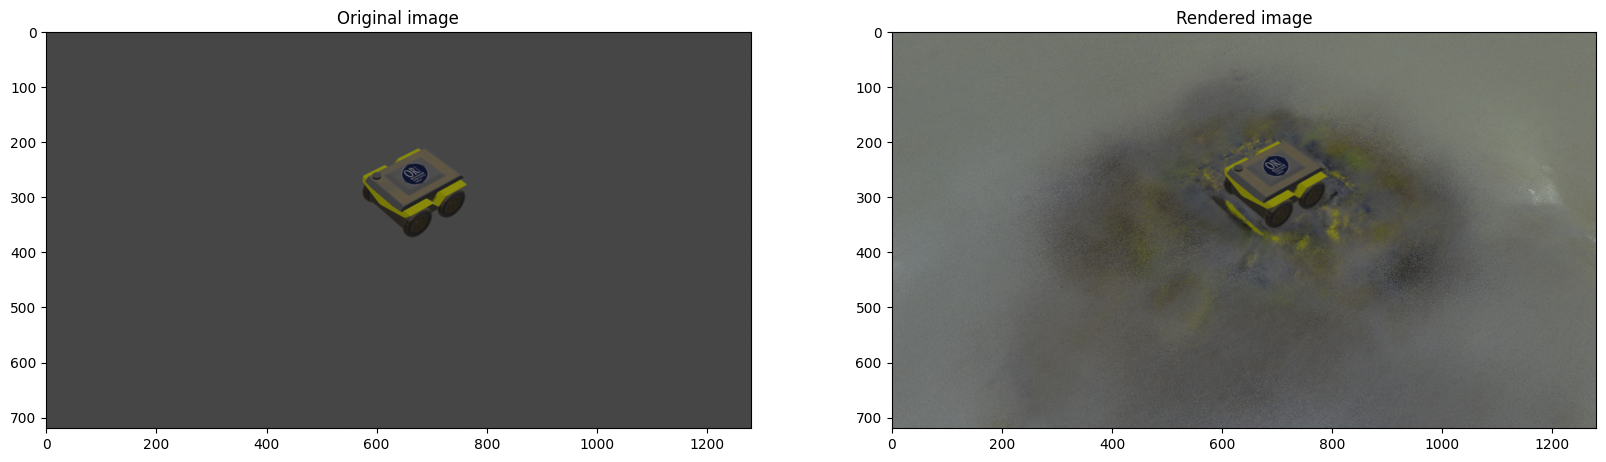

In [10]:
#Plot original image and rendered image
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(original_img)
ax[0].set_title("Original image")
ax[1].imshow(rendered_img)
ax[1].set_title("Rendered image")

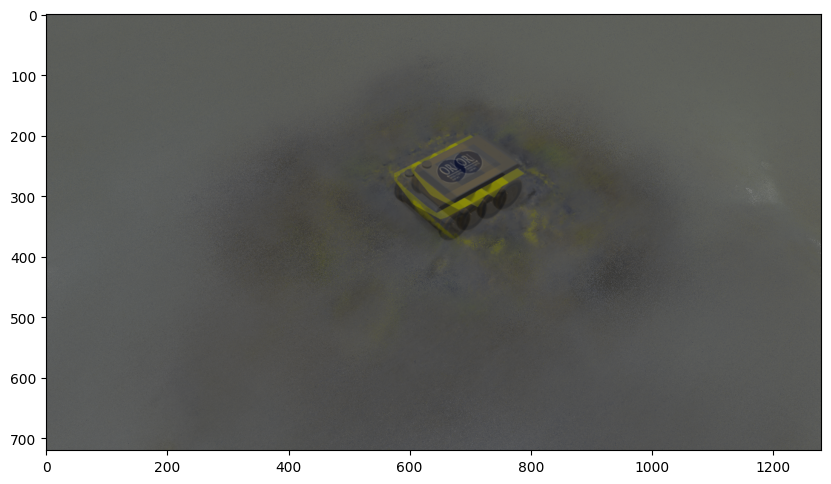

In [11]:
#Overlay original image and rendered image
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(rendered_img)
ax.imshow(original_img, alpha=0.5)

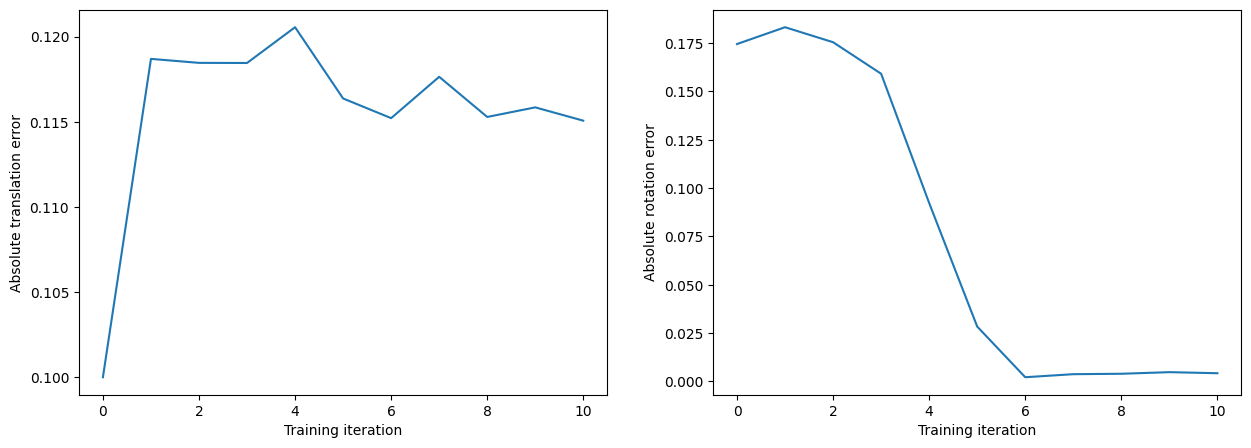

In [12]:
#Plot store_t_diff and store_r_diff with  respect to training iteration in 2 subplots

plotting_data = np.asarray(store.to("cpu"))
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(plotting_data[:, 0], plotting_data[:, 1])
plt.xlabel("Training iteration")
plt.ylabel("Absolute translation error")
plt.subplot(1, 2, 2)
plt.plot(plotting_data[:, 0], plotting_data[:, 2])
plt.xlabel("Training iteration")
plt.ylabel("Absolute rotation error")
plt.show()

In [13]:
batch = trainer.pipeline.datamanager.inerf_batch
ray_bundle = trainer.pipeline.datamanager.train_ray_generator(batch["indices"])

#Create blank 2D array
image = np.zeros((720, 1280, 3), dtype=np.float32)
cnt = np.zeros((720, 1280, 1), dtype=np.float32)

for i in range(len(batch['image'])):
    x,y = batch['indices'][i,1:]
    cnt[x,y] += 1
    image[x,y] = batch['image'][i,:3]

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

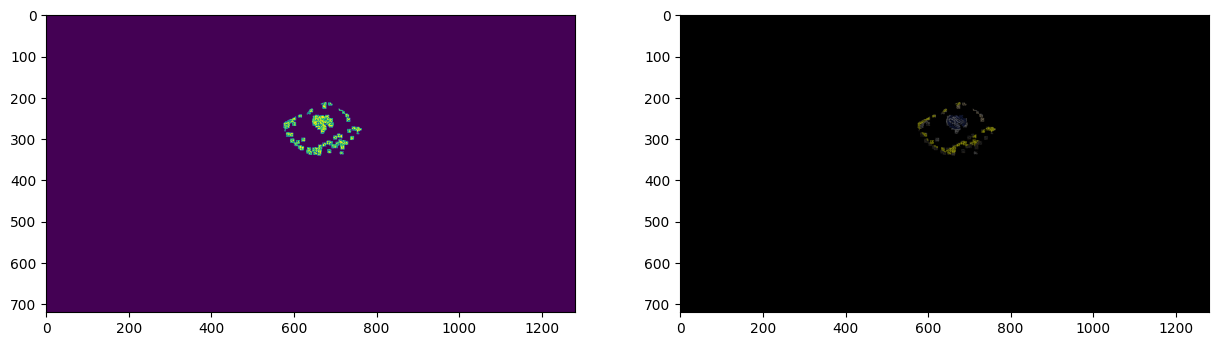

In [ ]:
# Plot cnt and image in subplot
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(cnt)
ax[1].imshow(image)
plt.show()